Class                   0
Alcohol                 0
Malic Acid              0
Ash                     0
Alcalinity of Ash       0
Magnesium               0
Total Phenols           0
Flavanoids              0
Nonflavanoid Phenols    0
Proanthocyanins         0
Color Intensity         0
Hue                     0
OD280/OD315             0
Proline                 0
dtype: int64


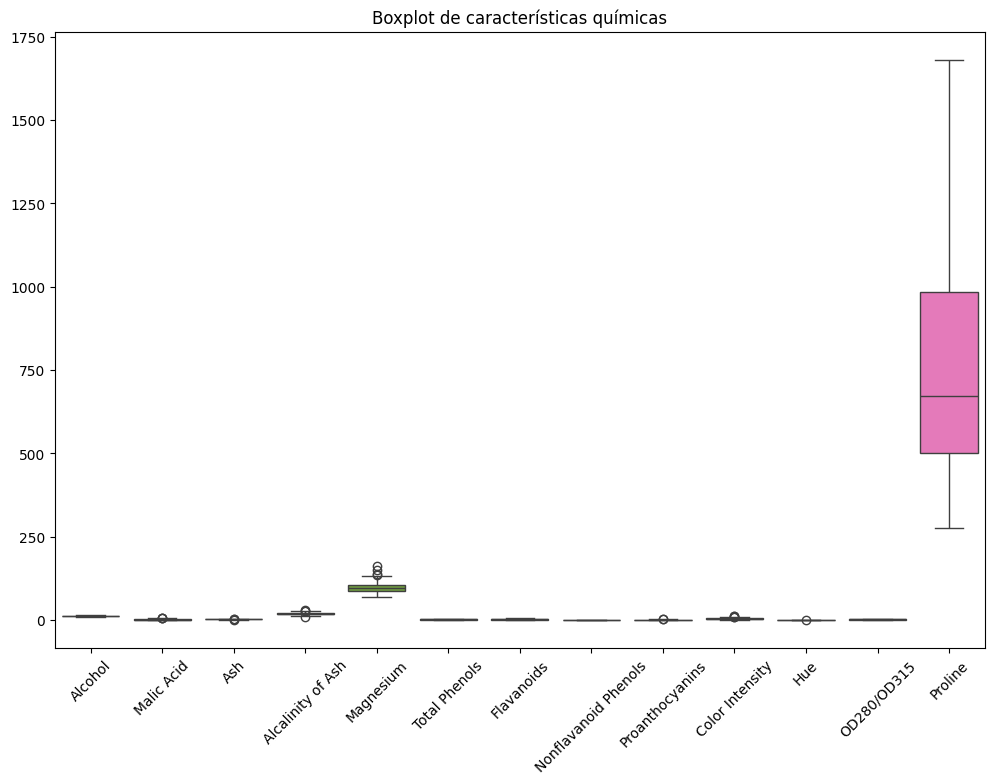

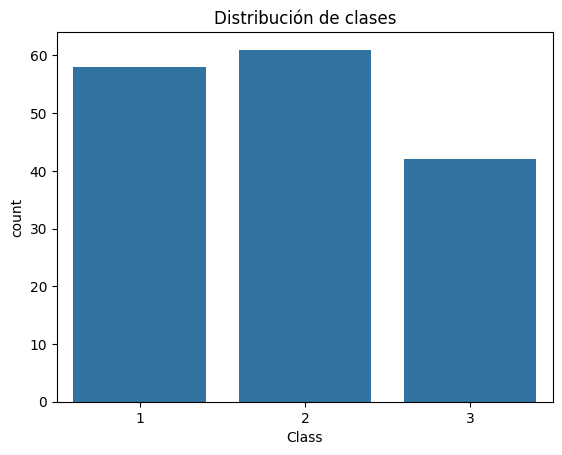

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        13
           2       1.00      0.92      0.96        13
           3       0.88      1.00      0.93         7

    accuracy                           0.97        33
   macro avg       0.96      0.97      0.96        33
weighted avg       0.97      0.97      0.97        33



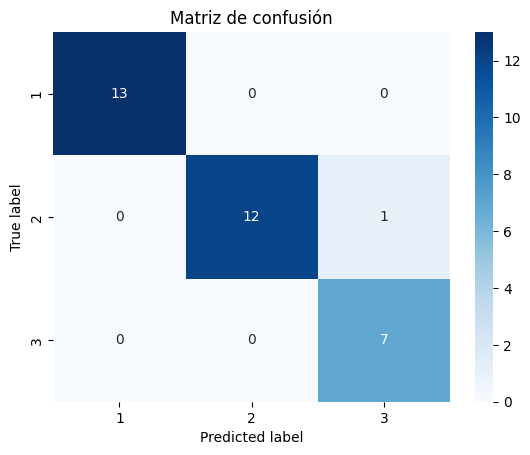

2024/10/17 17:33:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Predicciones para las nuevas muestras: [1 2]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import mlflow
import mlflow.sklearn

# Cargar datos
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data"
column_names = ['Class', 'Alcohol', 'Malic Acid', 'Ash', 'Alcalinity of Ash', 'Magnesium',
                'Total Phenols', 'Flavanoids', 'Nonflavanoid Phenols', 'Proanthocyanins',
                'Color Intensity', 'Hue', 'OD280/OD315', 'Proline']
data = pd.read_csv(url, names=column_names)

# Verificar datos faltantes
print(data.isnull().sum())

# Identificación de valores atípicos usando boxplots
plt.figure(figsize=(12, 8))
sns.boxplot(data=data.iloc[:, 1:])  # Excluyendo la columna de clase
plt.xticks(rotation=45)
plt.title("Boxplot de características químicas")
plt.show()

# Tratamiento de outliers (ejemplo usando IQR)
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1
data = data[~((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))).any(axis=1)]

# Balanceo de clases
sns.countplot(x='Class', data=data)
plt.title("Distribución de clases")
plt.show()

# Separar características y etiqueta
X = data.drop('Class', axis=1)
y = data['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Optimización de hiperparámetros
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)

# Mejor modelo
model = grid_search.best_estimator_
y_pred = model.predict(X_test_scaled)

# Clasificación y matriz de confusión
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Matriz de confusión')
plt.show()

# Registro con MLflow
mlflow.start_run()
mlflow.sklearn.log_model(model, "model")
mlflow.log_param("n_estimators", grid_search.best_params_['n_estimators'])
mlflow.log_param("max_depth", grid_search.best_params_['max_depth'])
mlflow.log_metric("accuracy", accuracy_score(y_test, y_pred))
mlflow.end_run()

# Predicción para nuevas muestras
new_samples = np.array([[13.72, 1.43, 2.5, 16.7, 108, 3.4, 3.67, 0.19, 2.04, 6.8, 0.89, 2.87, 1285],
                        [12.37, 0.94, 1.36, 10.6, 88, 1.98, 0.57, 0.28, 0.42, 1.95, 1.05, 1.82, 520]])
new_samples_scaled = scaler.transform(new_samples)
predictions = model.predict(new_samples_scaled)
print("Predicciones para las nuevas muestras:", predictions)
